In [1]:
import numpy as np
import matplotlib.pyplot as plt
from kernel import Kernel

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%matplotlib inline
plt.rcParams['text.latex.preamble'] = [r'\usepackage{newtxmath}'] 
plt.rcParams['text.usetex'] = True
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Times"
plt.rc('text', usetex=True)

/var/folders/yg/djxj05p562nc92kcrz6sfj3c0000gn/T/ipykernel_40376/3356598534.py:2: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  plt.rcParams['text.latex.preamble'] = [r'\usepackage{newtxmath}']


In [4]:
np.random.seed(0)

In [5]:
def target_func(x, omega=2*np.pi):
    return np.sin(omega * x)

def get_stepsize(T, gamma_0=1):
    gamma = np.arange(T, dtype=float)
    gamma += 1
    np.sqrt(gamma, out=gamma)
    np.divide(1, gamma, out=gamma)
    gamma *= gamma_0
    return gamma

n_exp = 100
n_train = int(1e4)
gamma_0 = 1
gamma = get_stepsize(n_train, gamma_0)

sigma = .2
kernel = Kernel('gaussian', sigma=sigma)

n_test = 100
x_test = np.linspace(0, 1, n_test, dtype=np.float32)
y_test = target_func(x_test)

alpha = np.zeros(n_train, np.float32)
average_alpha = np.zeros(n_train, np.float32)
error = np.zeros((n_exp, n_train), np.float32)

alpha_bis = np.zeros(n_train, np.float32)
average_alpha_bis = np.zeros(n_train, np.float32)
error_bis = np.zeros((n_exp, n_train), np.float32)

y_pred = np.zeros(n_test, np.float32)
K = np.zeros((n_train, n_train), dtype=np.float32)
k_test = np.zeros((n_test, n_train), dtype=np.float32)

for j in range(n_exp):

    x_train = np.random.rand(n_train)[:, np.newaxis].astype(np.float32)
    kernel.set_support(x_train)
    K[:] = kernel(x_train)
    k_test[:] = kernel(x_test[:, np.newaxis]).T

    u = np.random.randn(n_train)
    err_u = np.sign(u - target_func(x_train[:,0]))

    alpha[:] = 0
    alpha_bis[:] = 0
    average_alpha[:] = 0
    average_alpha_bis[:] = 0
    for i in range(n_train):
        z = K[i] @ alpha
        epsilon = np.sign(z - target_func(x_train[i,0]))
        alpha[i] -= epsilon * gamma[i]
        average_alpha += alpha

        err = np.sign(u[i] - K[i] @ alpha_bis)
        err_u[i] -= err
        err_u[i] = np.abs(err_u[i]) / 2
        err_u[i] *= err
        alpha_bis[i] += err_u[i] * gamma[i]
        average_alpha_bis += alpha_bis

        y_pred[:] = k_test @ average_alpha 
        y_pred /= i+1
        y_pred -= y_test
        np.abs(y_pred, out=y_pred)
        error[j, i] = y_pred.mean()

        y_pred[:] = k_test @ average_alpha_bis
        y_pred /= i+1
        y_pred -= y_test
        np.abs(y_pred, out=y_pred)
        error_bis[j, i] = y_pred.mean()
    print(j, end=',')

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,

In [6]:
ave_error = error.mean(axis=0)
std_error = error.std(axis=0)
ave_error_bis = error_bis.mean(axis=0)
std_error_bis = error_bis.std(axis=0)

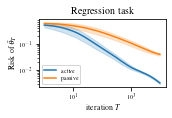

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(2.5, 1.75))
ax.fill_between(np.arange(n_train) + 1, ave_error + std_error, ave_error - std_error, color='C0', alpha=.2)
a, = ax.plot(np.arange(n_train) + 1, ave_error, c='C0')
ax.fill_between(np.arange(n_train) + 1, ave_error_bis + std_error_bis, ave_error_bis - std_error_bis, color='C1', alpha=.2)
b, = ax.plot(np.arange(n_train) + 1, ave_error_bis, c='C1')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend([a, b], ['active', 'passive'], prop={'size': 6})
plt.yticks(fontsize=6)
plt.xticks(fontsize=6)
ax.set_title(r'Regression task', size=10)
ax.set_xlabel(r"iteration $T$", size=8)
ax.set_ylabel(r"Risk of $\bar\theta_T$", size=8)
fig.tight_layout()
fig.savefig("regression_error.pdf")